**Dependencies**

In [1]:
!pip install tensorflow
!pip install pyshacl
!pip install rdflib
!pip install rdflib-jsonld
!pip install mxnet
!pip install numpy
!pip install scipy
!pip install opencv-python
!pip install pickle5

In [2]:
!pip install --upgrade pip==20.2
!pip install -U 'model-card-toolkit>=0.1.1,<0.2'
!pip install -U seaborn scikit-learn 

Requirement already up-to-date: pip==20.2 in /usr/local/lib/python3.7/dist-packages (20.2)
Requirement already up-to-date: model-card-toolkit<0.2,>=0.1.1 in /usr/local/lib/python3.7/dist-packages (0.1.3)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-transform 0.26.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,<2.4,>=1.15.2, but you'll have tensorflow 2.8.0 which is incompatible.
tensorflow-model-analysis 0.26.1 requires numpy<1.20,>=1.16, but you'll have numpy 1.21.6 which is incompatible.
apache-beam 2.28.0 requires numpy<1.20.0,>=1.14.3,

Import Packages

In [3]:
from datetime import date
from io import BytesIO
from IPython import display
import model_card_toolkit as mctlib
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

In [4]:
import tensorflow as tf
from scipy import misc
import numpy as np
import mxnet as mx
import argparse
import random
import pickle
import cv2
import os

Two ways to load the dataset:
1. Download and unzip the dataset to the google colab files

In [5]:
#!wget --no-check-certificate https://www2.macs.hw.ac.uk/~js2001/datasets.zip
#!unzip datasets.zip -d ./

2. Mount Google Cloud Disk to load dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets.zip -d ./

Mounted at /content/drive/
Archive:  /content/drive/MyDrive/Colab Notebooks/datasets.zip
   creating: ./faces_ms1m_112x112/
  inflating: ./faces_ms1m_112x112/agedb_30.bin  
  inflating: ./faces_ms1m_112x112/calfw.bin  
  inflating: ./faces_ms1m_112x112/cfp_ff.bin  
  inflating: ./faces_ms1m_112x112/cfp_fp.bin  
  inflating: ./faces_ms1m_112x112/cplfw.bin  
  inflating: ./faces_ms1m_112x112/lfw.bin  
  inflating: ./faces_ms1m_112x112/property  
  inflating: ./faces_ms1m_112x112/train.idx  
  inflating: ./faces_ms1m_112x112/train.rec  
  inflating: ./faces_ms1m_112x112/vgg2_fp.bin  


Prepare Dataset

In [7]:
def parse_args():
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='data path information'
    )
    parser.add_argument('--bin_path', default='./faces_ms1m_112x112/train.rec', type=str,
                        help='path to the binary image file')
    parser.add_argument('--idx_path', default='./faces_ms1m_112x112/train.idx', type=str,
                        help='path to the image index path')
    parser.add_argument('--tfrecords_file_path', default='../tfrecords', type=str,
                        help='path to the output of tfrecords file path')
    args = parser.parse_args()
    return args

def mx2tfrecords(imgidx, imgrec, args):
    output_path = os.path.join(args.tfrecords_file_path, 'tran.tfrecords')
    if not os.path.exists(args.tfrecords_file_path):
        os.makedirs(args.tfrecords_file_path)
    writer = tf.python_io.TFRecordWriter(output_path)
    random.shuffle(imgidx)
    for i, index in enumerate(imgidx):
        img_info = imgrec.read_idx(index)
        header, img = mx.recordio.unpack(img_info)
        label = int(header.label)
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img])),
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }))
        writer.write(example.SerializeToString())  # Serialize To String
        if i % 10000 == 0:
            print('%d num image processed' % i)
    print('%d num image processed' % i)
    writer.close()

def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return misc.imrotate(image, angle, 'bicubic')

def parse_function(example_proto):
    features = {'image_raw': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)}
    features = tf.parse_single_example(example_proto, features)
    # You can do more image distortion here for training data
    img = tf.image.decode_jpeg(features['image_raw'])
    img = tf.reshape(img, shape=(112, 112, 3))

    #img = tf.py_func(random_rotate_image, [img], tf.uint8)
    img = tf.cast(img, dtype=tf.float32)
    img = tf.subtract(img, 127.5)
    img = tf.multiply(img,  0.0078125)
    img = tf.image.random_flip_left_right(img)
    label = tf.cast(features['label'], tf.int64)
    return img, label

def create_tfrecords():
    '''convert mxnet data to tfrecords.'''
    id2range = {}
    args = parse_args()

    imgrec = mx.recordio.MXIndexedRecordIO(args.idx_path, args.bin_path, 'r')
    s = imgrec.read_idx(0)
    header, _ = mx.recordio.unpack(s)
    #print(header.label)
    imgidx = list(range(1, int(header.label[0])))
    seq_identity = range(int(header.label[0]), int(header.label[1]))
    for identity in seq_identity:
        s = imgrec.read_idx(identity)
        header, _ = mx.recordio.unpack(s)
        a, b = int(header.label[0]), int(header.label[1])
        id2range[identity] = (a, b)
    print('id2range', len(id2range))
    print('Number of examples in training set: {}'.format(imgidx[-1]))

    # generate tfrecords
    mx2tfrecords(imgidx, imgrec, args)

def load_bin(db_name, image_size, args):
    bins, issame_list = pickle.load(open(os.path.join(args.eval_db_path, db_name+'.bin'), 'rb'), encoding='bytes')
    data_list = []
    for _ in [0,1]:
        data = np.empty((len(issame_list)*2, image_size[0], image_size[1], 3))
        data_list.append(data)
    for i in range(len(issame_list)*2):
        _bin = bins[i]
        img = mx.image.imdecode(_bin).asnumpy()
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        for flip in [0,1]:
            if flip == 1:
                img = np.fliplr(img)
            data_list[flip][i, ...] = img
        i += 1
        if i % 1000 == 0:
            print('loading bin', i)
    print(data_list[0].shape)

    return data_list, issame_list

def load_data(db_name, image_size, args):
    bins, issame_list = pickle.load(open(os.path.join(args.eval_db_path, db_name+'.bin'), 'rb'), encoding='bytes')
    datasets = np.empty((len(issame_list)*2, image_size[0], image_size[1], 3))

    for i in range(len(issame_list)*2):
        _bin = bins[i]
        img = mx.image.imdecode(_bin).asnumpy()
        # img = cv2.imdecode(np.fromstring(_bin, np.uint8), -1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = img - 127.5
        img = img * 0.0078125
        datasets[i, ...] = img
        i += 1
        if i % 1000 == 0:
            print('loading bin', i)
    print(datasets.shape)

    return datasets, issame_list

def test_tfrecords():
    args = parse_args()

    config = tf.ConfigProto(allow_soft_placement=True)
    sess = tf.Session(config=config)
    # training datasets api config
    tfrecords_f = os.path.join(args.tfrecords_file_path, 'tran.tfrecords')
    dataset = tf.data.TFRecordDataset(tfrecords_f)
    dataset = dataset.map(parse_function)
    dataset = dataset.shuffle(buffer_size=20000)
    dataset = dataset.batch(32)
    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()
    # begin iteration
    for i in range(1000):
        sess.run(iterator.initializer)
        while True:
            try:
                images, labels = sess.run(next_element)
                img = cv2.cvtColor(images[1, ...], cv2.COLOR_RGB2BGR)
                cv2.imshow('test', img)
                cv2.waitKey(0)
            except tf.errors.OutOfRangeError:
                print("End of dataset")

Face Losses Func

In [8]:
import tensorflow as tf
import math


def insightface_loss(embedding, labels, out_num, w_init=None, s=64., m=0.5):
    '''
    :param embedding: the input embedding vectors
    :param labels:  the input labels, the shape should be eg: (batch_size, 1)
    :param s: scalar value default is 64
    :param out_num: output class num
    :param m: the margin value, default is 0.5
    :return: the final cacualted output, this output is send into the tf.nn.softmax directly
    '''
    cos_m = math.cos(m)
    sin_m = math.sin(m)
    mm = sin_m * m  # issue 1
    threshold = math.cos(math.pi - m)
    with tf.variable_scope('insightface_loss'):
        # inputs and weights norm
        embedding_norm = tf.norm(embedding, axis=1, keepdims=True)
        embedding = tf.div(embedding, embedding_norm, name='norm_embedding')
        weights = tf.get_variable(name='embedding_weights', shape=(embedding.get_shape().as_list()[-1], out_num),
                                  initializer=w_init, dtype=tf.float32)
        weights_norm = tf.norm(weights, axis=0, keepdims=True)
        weights = tf.div(weights, weights_norm, name='norm_weights')
        # cos(theta+m)
        cos_t = tf.matmul(embedding, weights, name='cos_t')
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')

        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_t - threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

        keep_val = s*(cos_t - mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)

        mask = tf.one_hot(labels, depth=out_num, name='one_hot_mask')
        # mask = tf.squeeze(mask, 1)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')

        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')

        logit = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_loss_output')
        inference_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=labels))

    return inference_loss, logit


def cosineface_loss(embedding, labels, out_num, w_init=None, s=30., m=0.4):
    '''
    :param embedding: the input embedding vectors
    :param labels:  the input labels, the shape should be eg: (batch_size, 1)
    :param s: scalar value, default is 30
    :param out_num: output class num
    :param m: the margin value, default is 0.4
    :return: the final cacualted output, this output is send into the tf.nn.softmax directly
    '''
    with tf.variable_scope('cosineface_loss'):
        # inputs and weights norm
        embedding_norm = tf.norm(embedding, axis=1, keep_dims=True)
        embedding = tf.div(embedding, embedding_norm, name='norm_embedding')
        weights = tf.get_variable(name='embedding_weights', shape=(embedding.get_shape().as_list()[-1], out_num),
                                  initializer=w_init, dtype=tf.float32)
        weights_norm = tf.norm(weights, axis=0, keep_dims=True)
        weights = tf.div(weights, weights_norm, name='norm_weights')
        # cos_theta - m
        cos_t = tf.matmul(embedding, weights, name='cos_t')
        cos_t_m = tf.subtract(cos_t, m, name='cos_t_m')

        mask = tf.one_hot(labels, depth=out_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')

        logit = tf.add(s * tf.multiply(cos_t, inv_mask), s * tf.multiply(cos_t_m, mask), name='cosineface_loss_output')
        inference_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=labels))

    return inference_loss, logit


def combine_loss(embedding, labels, batch_size, out_num, w_init, margin_a=1., margin_m=0.3, margin_b=0.2, s=64.):
    '''
    This code is contributed by RogerLo. Thanks for you contribution.

    :param embedding: the input embedding vectors
    :param labels:  the input labels, the shape should be eg: (batch_size, 1)
    :param s: scalar value default is 64
    :param batch_size: input batch size
    :param out_num: output class num
    :param m: the margin value, default is 0.5
    :return: the final cacualted output, this output is send into the tf.nn.softmax directly
    '''
    with tf.variable_scope('combine_loss'):
        weights = tf.get_variable(name='embedding_weights', shape=(embedding.get_shape().as_list()[-1], out_num),
                                  initializer=w_init, dtype=tf.float32)
        weights_unit = tf.nn.l2_normalize(weights, axis=0)
        embedding_unit = tf.nn.l2_normalize(embedding, axis=1)
        cos_t = tf.matmul(embedding_unit, weights_unit)
        ordinal = tf.constant(list(range(0, batch_size)), tf.int64)
        ordinal_y = tf.stack([ordinal, labels], axis=1)
        zy = cos_t * s
        sel_cos_t = tf.gather_nd(zy, ordinal_y)
        if margin_a != 1.0 or margin_m != 0.0 or margin_b != 0.0:
            if margin_a == 1.0 and margin_m == 0.0:
                s_m = s * margin_b
                new_zy = sel_cos_t - s_m
            else:
                cos_value = sel_cos_t / s
                t = tf.acos(cos_value)
                if margin_a != 1.0:
                    t = t * margin_a
                if margin_m > 0.0:
                    t = t + margin_m
                body = tf.cos(t)
                if margin_b > 0.0:
                    body = body - margin_b
                new_zy = body * s
        updated_logits = tf.add(zy, tf.scatter_nd(ordinal_y, tf.subtract(new_zy, sel_cos_t), (batch_size, out_num)))
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=updated_logits))
        # predict_cls = tf.argmax(updated_logits, 1)
        # accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(predict_cls, tf.int64), tf.cast(labels, tf.int64)), 'float'))
        # predict_cls_s = tf.argmax(zy, 1)
        # accuracy_s = tf.reduce_mean(tf.cast(tf.equal(tf.cast(predict_cls_s, tf.int64), tf.cast(labels, tf.int64)), 'float'))
        # return zy, loss, accuracy, accuracy_s, predict_cls_s

    return loss, updated_logits

def center_loss(features, label, alfa, nrof_classes):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    nrof_features = features.get_shape()[1]
    centers = tf.get_variable('centers', [nrof_classes, nrof_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    label = tf.reshape(label, [-1])
    centers_batch = tf.gather(centers, label)
    diff = (1 - alfa) * (centers_batch - features)
    centers = tf.scatter_sub(centers, label, diff)
    with tf.control_dependencies([centers]):
        loss = tf.reduce_mean(tf.square(features - centers_batch))
    return loss, centers


def cos_loss(x, y, num_cls, reuse=False, alpha=0.35, scale=64, name='cos_loss'):
    '''
    x: B x D - features
    y: B x 1 - labels
    num_cls: 1 - total class number
    alpah: 1 - margin
    scale: 1 - scaling paramter
    '''
    # define the classifier weights
    xs = x.get_shape()
    with tf.variable_scope('centers_var', reuse=reuse) as center_scope:
        w = tf.get_variable("centers", [xs[1], num_cls], dtype=tf.float32,
                            initializer=tf.contrib.layers.xavier_initializer(), trainable=True)

    # normalize the feature and weight
    # (N,D)
    x_feat_norm = tf.nn.l2_normalize(x, 1, 1e-10)
    # (D,C)
    w_feat_norm = tf.nn.l2_normalize(w, 0, 1e-10)

    # get the scores after normalization
    # (N,C)
    xw_norm = tf.matmul(x_feat_norm, w_feat_norm)
    # implemented by py_func
    # value = tf.identity(xw)
    # substract the marigin and scale it
    # value = coco_func(xw_norm,y,alpha) * scale

    # implemented by tf api
    margin_xw_norm = xw_norm - alpha
    label_onehot = tf.one_hot(y, num_cls)
    value = scale * tf.where(tf.equal(label_onehot, 1), margin_xw_norm, xw_norm)

    # compute the loss as softmax loss
    cos_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=value))

    return cos_loss, value

Data Process Func

In [9]:
def parse_args():
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='data path information'
    )
    parser.add_argument('--bin_path', default='./faces_ms1m_112x112/train.rec', type=str,
                        help='path to the binary image file')
    parser.add_argument('--idx_path', default='./faces_ms1m_112x112/train.idx', type=str,
                        help='path to the image index path')
    parser.add_argument('--tfrecords_file_path', default='../tfrecords', type=str,
                        help='path to the output of tfrecords file path')
    args = parser.parse_args()
    return args

def mx2tfrecords(imgidx, imgrec, args):
    output_path = os.path.join(args.tfrecords_file_path, 'tran.tfrecords')
    if not os.path.exists(args.tfrecords_file_path):
        os.makedirs(args.tfrecords_file_path)
    writer = tf.python_io.TFRecordWriter(output_path)
    random.shuffle(imgidx)
    for i, index in enumerate(imgidx):
        img_info = imgrec.read_idx(index)
        header, img = mx.recordio.unpack(img_info)
        label = int(header.label)
        example = tf.train.Example(features=tf.train.Features(feature={
            'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img])),
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }))
        writer.write(example.SerializeToString())  # Serialize To String
        if i % 10000 == 0:
            print('%d num image processed' % i)
    print('%d num image processed' % i)
    writer.close()

def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return misc.imrotate(image, angle, 'bicubic')

def parse_function(example_proto):
    features = {'image_raw': tf.FixedLenFeature([], tf.string),
                'label': tf.FixedLenFeature([], tf.int64)}
    features = tf.parse_single_example(example_proto, features)
    # You can do more image distortion here for training data
    img = tf.image.decode_jpeg(features['image_raw'])
    img = tf.reshape(img, shape=(112, 112, 3))

    #img = tf.py_func(random_rotate_image, [img], tf.uint8)
    img = tf.cast(img, dtype=tf.float32)
    img = tf.subtract(img, 127.5)
    img = tf.multiply(img,  0.0078125)
    img = tf.image.random_flip_left_right(img)
    label = tf.cast(features['label'], tf.int64)
    return img, label

def create_tfrecords():
    '''convert mxnet data to tfrecords.'''
    id2range = {}
    args = parse_args()

    imgrec = mx.recordio.MXIndexedRecordIO(args.idx_path, args.bin_path, 'r')
    s = imgrec.read_idx(0)
    header, _ = mx.recordio.unpack(s)
    #print(header.label)
    imgidx = list(range(1, int(header.label[0])))
    seq_identity = range(int(header.label[0]), int(header.label[1]))
    for identity in seq_identity:
        s = imgrec.read_idx(identity)
        header, _ = mx.recordio.unpack(s)
        a, b = int(header.label[0]), int(header.label[1])
        id2range[identity] = (a, b)
    print('id2range', len(id2range))
    print('Number of examples in training set: {}'.format(imgidx[-1]))

    # generate tfrecords
    mx2tfrecords(imgidx, imgrec, args)

def load_bin(db_name, image_size, args):
    bins, issame_list = pickle.load(open(os.path.join(args.eval_db_path, db_name+'.bin'), 'rb'), encoding='bytes')
    data_list = []
    for _ in [0,1]:
        data = np.empty((len(issame_list)*2, image_size[0], image_size[1], 3))
        data_list.append(data)
    for i in range(len(issame_list)*2):
        _bin = bins[i]
        img = mx.image.imdecode(_bin).asnumpy()
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        for flip in [0,1]:
            if flip == 1:
                img = np.fliplr(img)
            data_list[flip][i, ...] = img
        i += 1
        if i % 1000 == 0:
            print('loading bin', i)
    print(data_list[0].shape)

    return data_list, issame_list

def load_data(db_name, image_size, args):
    bins, issame_list = pickle.load(open(os.path.join(args.eval_db_path, db_name+'.bin'), 'rb'), encoding='bytes')
    datasets = np.empty((len(issame_list)*2, image_size[0], image_size[1], 3))

    for i in range(len(issame_list)*2):
        _bin = bins[i]
        img = mx.image.imdecode(_bin).asnumpy()
        # img = cv2.imdecode(np.fromstring(_bin, np.uint8), -1)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = img - 127.5
        img = img * 0.0078125
        datasets[i, ...] = img
        i += 1
        if i % 1000 == 0:
            print('loading bin', i)
    print(datasets.shape)

    return datasets, issame_list

def test_tfrecords():
    args = parse_args()

    config = tf.ConfigProto(allow_soft_placement=True)
    sess = tf.Session(config=config)
    # training datasets api config
    tfrecords_f = os.path.join(args.tfrecords_file_path, 'tran.tfrecords')
    dataset = tf.data.TFRecordDataset(tfrecords_f)
    dataset = dataset.map(parse_function)
    dataset = dataset.shuffle(buffer_size=20000)
    dataset = dataset.batch(32)
    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()
    # begin iteration
    for i in range(1000):
        sess.run(iterator.initializer)
        while True:
            try:
                images, labels = sess.run(next_element)
                img = cv2.cvtColor(images[1, ...], cv2.COLOR_RGB2BGR)
                cv2.imshow('test', img)
                cv2.waitKey(0)
            except tf.errors.OutOfRangeError:
                print("End of dataset")


FaceMobileNet Main Part

In [10]:
# Copyright 2018 The AI boy xsr-ai. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =============================================================================
"""MobileFaceNets.

MobileFaceNets, which use less than 1 million parameters and are specifically tailored for high-accuracy real-time
face verification on mobile and embedded devices.

here is MobileFaceNets architecture, reference from MobileNet_V2 (https://github.com/xsr-ai/MobileNetv2_TF).

As described in https://arxiv.org/abs/1804.07573.

  MobileFaceNets: Efficient CNNs for Accurate Real-time Face Verification on Mobile Devices

  Sheng Chen, Yang Liu, Xiang Gao, Zhen Han

"""

# Tensorflow mandates these.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import namedtuple
import functools

import tensorflow as tf

# slim = tf.contrib.slim
slim = tf.compat.v1.estimator

# Conv and InvResBlock namedtuple define layers of the MobileNet architecture
# Conv defines 3x3 convolution layers
# InvResBlock defines 3x3 depthwise convolution followed by 1x1 convolution.
# stride is the stride of the convolution
# depth is the number of channels or filters in a layer
Conv = namedtuple('Conv', ['kernel', 'stride', 'depth', 'ratio'])
DepthwiseConv = namedtuple('DepthwiseConv', ['kernel', 'stride', 'depth', 'ratio'])
InvResBlock = namedtuple('InvResBlock', ['kernel', 'stride', 'depth', 'ratio', 'repeate'])

# _CONV_DEFS specifies the MobileNet body
_CONV_DEFS = [
    Conv(kernel=[3, 3], stride=2, depth=64, ratio=1),
    DepthwiseConv(kernel=[3, 3], stride=1, depth=64, ratio=1),

    InvResBlock(kernel=[3, 3], stride=2, depth=64, ratio=2, repeate=5),
    InvResBlock(kernel=[3, 3], stride=2, depth=128, ratio=4, repeate=1),
    InvResBlock(kernel=[3, 3], stride=1, depth=128, ratio=2, repeate=6),
    InvResBlock(kernel=[3, 3], stride=2, depth=128, ratio=4, repeate=1),
    InvResBlock(kernel=[3, 3], stride=1, depth=128, ratio=2, repeate=2),

    Conv(kernel=[1, 1], stride=1, depth=512, ratio=1),
]

def inverted_block(net, input_filters, output_filters, expand_ratio, stride, scope=None):
    '''fundamental network struture of inverted residual block'''
    with tf.name_scope(scope):
        res_block = slim.conv2d(inputs=net, num_outputs=input_filters * expand_ratio, kernel_size=[1, 1])
        # depthwise conv2d
        res_block = slim.separable_conv2d(inputs=res_block, num_outputs=None, kernel_size=[3, 3], stride=stride, depth_multiplier=1.0, normalizer_fn=slim.batch_norm)
        res_block = slim.conv2d(inputs=res_block, num_outputs=output_filters, kernel_size=[1, 1], activation_fn=None)
        # stride 2 blocks
        if stride == 2:
            return res_block
        # stride 1 block
        else:
            if input_filters != output_filters:
                net = slim.conv2d(inputs=net, num_outputs=output_filters, kernel_size=[1, 1], activation_fn=None)
            return tf.add(res_block, net)

def mobilenet_v2_base(inputs,
                      final_endpoint='Conv2d_7',
                      min_depth=8,
                      conv_defs=None,
                      scope=None):
  """Mobilenet v2.

  Constructs a Mobilenet v2 network from inputs to the given final endpoint.

  Args:
    inputs: a tensor of shape [batch_size, height, width, channels].
    final_endpoint: specifies the endpoint to construct the network up to. It
      can be one of ['Conv2d_0', 'Conv2d_1_InvResBlock', 'Conv2d_2_InvResBlock',
      'Conv2d_3_InvResBlock', 'Conv2d_4_InvResBlock', 'Conv2d_5_InvResBlock,
      'Conv2d_6_InvResBlock', 'Conv2d_7_InvResBlock', 'Conv2d_8'].
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced output depth to min_depth.
    conv_defs: A list of ConvDef namedtuples specifying the net architecture.
    scope: Optional variable_scope.

  Returns:
    tensor_out: output tensor corresponding to the final_endpoint.
    end_points: a set of activations for external use, for example summaries or
                losses.

  Raises:
    ValueError: if final_endpoint is not set to one of the predefined values
                is not allowed.
  """
  depth = lambda d: max(int(d), min_depth)
  end_points = {}

  if conv_defs is None:
    conv_defs = _CONV_DEFS

  with tf.variable_scope(scope, 'MobileFaceNet', [inputs]):
    with slim.arg_scope([slim.conv2d, slim.separable_conv2d], padding='SAME'):

      net = inputs
      for i, conv_def in enumerate(conv_defs):
        end_point_base = 'Conv2d_%d' % i

        if isinstance(conv_def, Conv):
          end_point = end_point_base
          net = slim.conv2d(net, depth(conv_def.depth), conv_def.kernel,
                            stride=conv_def.stride,
                            normalizer_fn=slim.batch_norm,
                            scope=end_point)
          end_points[end_point] = net
          if end_point == final_endpoint:
            return net, end_points

        elif isinstance(conv_def, DepthwiseConv):
            end_point = 'DepthwiseConv'
            # depthwise conv2d
            net = slim.separable_conv2d(inputs=net, num_outputs=None, kernel_size=conv_def.kernel, stride=conv_def.stride,
                                        depth_multiplier=1.0, normalizer_fn=slim.batch_norm)
            net = slim.conv2d(inputs=net, num_outputs=conv_def.depth, kernel_size=[1, 1], activation_fn=None)
            end_points[end_point] = net
            if end_point == final_endpoint:
                return net, end_points

        elif isinstance(conv_def, InvResBlock):
          end_point = end_point_base + '_InvResBlock'
          # inverted bottleneck blocks
          input_filters = net.shape[3].value
          # first layer needs to consider stride
          net = inverted_block(net, input_filters, depth(conv_def.depth), conv_def.ratio, conv_def.stride, end_point+'_0')
          for index in range(1, conv_def.repeate):
              suffix = '_' + str(index)
              net = inverted_block(net, input_filters, depth(conv_def.depth), conv_def.ratio, 1, end_point+suffix)

          end_points[end_point] = net
          if end_point == final_endpoint:
            return net, end_points

        else:
          raise ValueError('Unknown convolution type %s for layer %d'
                           % (conv_def.ltype, i))
  raise ValueError('Unknown final endpoint %s' % final_endpoint)


def mobilenet_v2(inputs,
                 bottleneck_layer_size=128,
                 is_training=False,
                 min_depth=8,
                 conv_defs=None,
                 spatial_squeeze=True,
                 reuse=None,
                 scope='MobileFaceNet',
                 global_pool=False):
  """Mobilenet v2 model for classification.

  Args:
    inputs: a tensor of shape [batch_size, height, width, channels].
    bottleneck_layer_size: number of predicted classes. If 0 or None, the logits layer
      is omitted and the input features to the logits layer (before dropout)
      are returned instead.
    is_training: whether is training or not.
    min_depth: Minimum depth value (number of channels) for all convolution ops.
      Enforced output depth to min_depth..
    conv_defs: A list of ConvDef namedtuples specifying the net architecture.
    spatial_squeeze: if True, logits is of shape is [B, C], if false logits is
        of shape [B, 1, 1, C], where B is batch_size and C is number of classes.
    reuse: whether or not the network and its variables should be reused. To be
      able to reuse 'scope' must be given.
    scope: Optional variable_scope.
    global_pool: Optional boolean flag to control the avgpooling before the
      logits layer. If false or unset, pooling is done with a fixed window
      that reduces default-sized inputs to 1x1, while larger inputs lead to
      larger outputs. If true, any input size is pooled down to 1x1.

  Returns:
    net: a 2D Tensor with the logits (pre-softmax activations) if bottleneck_layer_size
      is a non-zero integer, or the non-dropped-out input to the logits layer
      if bottleneck_layer_size is 0 or None.
    end_points: a dictionary from components of the network to the corresponding
      activation.

  Raises:
    ValueError: Input rank is invalid.
  """
  input_shape = inputs.get_shape().as_list()
  if len(input_shape) != 4:
    raise ValueError('Invalid input tensor rank, expected 4, was: %d' %
                     len(input_shape))

  with tf.variable_scope(scope, 'MobileFaceNet', [inputs], reuse=reuse) as scope:
    with slim.arg_scope([slim.batch_norm, slim.dropout], is_training=is_training):
      net, end_points = mobilenet_v2_base(inputs, scope=scope, min_depth=min_depth, conv_defs=conv_defs)

      with tf.variable_scope('Logits'):
        if global_pool:
          # Global average pooling.
          net = tf.reduce_mean(net, [1, 2], keep_dims=True, name='global_pool')
          end_points['global_pool'] = net
        else:
          # Pooling with a fixed kernel size.
          kernel_size = _reduced_kernel_size_for_small_input(net, [7, 7])

          # Global depthwise conv2d
          net = slim.separable_conv2d(inputs=net, num_outputs=None, kernel_size=kernel_size, stride=1,
                                      depth_multiplier=1.0, activation_fn=None, padding='VALID')
          net = slim.conv2d(inputs=net, num_outputs=512, kernel_size=[1, 1], stride=1, activation_fn=None, padding='VALID')
          end_points['GDConv'] = net

        if not bottleneck_layer_size:
          return net, end_points
        # 1 x 1 x 1024
        # net = slim.dropout(net, keep_prob=dropout_keep_prob, scope='Dropout_1b')
        logits = slim.conv2d(net, bottleneck_layer_size, kernel_size=[1, 1], stride=1, activation_fn=None, scope='LinearConv1x1')

        if spatial_squeeze:
          logits = tf.squeeze(logits, [1, 2], name='SpatialSqueeze')
      end_points['Logits'] = logits

  return logits, end_points

mobilenet_v2.default_image_size = 112


def wrapped_partial(func, *args, **kwargs):
  partial_func = functools.partial(func, *args, **kwargs)
  functools.update_wrapper(partial_func, func)
  return partial_func

def _reduced_kernel_size_for_small_input(input_tensor, kernel_size):
  """Define kernel size which is automatically reduced for small input.

  If the shape of the input images is unknown at graph construction time this
  function assumes that the input images are large enough.

  Args:
    input_tensor: input tensor of size [batch_size, height, width, channels].
    kernel_size: desired kernel size of length 2: [kernel_height, kernel_width]

  Returns:
    a tensor with the kernel size.
  """
  shape = input_tensor.get_shape().as_list()
  if shape[1] is None or shape[2] is None:
    kernel_size_out = kernel_size
  else:
    kernel_size_out = [min(shape[1], kernel_size[0]),
                       min(shape[2], kernel_size[1])]
  return kernel_size_out

def prelu(input, name=''):
    alphas = tf.get_variable(name=name + 'prelu_alphas',initializer=tf.constant(0.25,dtype=tf.float32,shape=[input.get_shape()[-1]]))
    pos = tf.nn.relu(input)
    neg = alphas * (input - abs(input)) * 0.5
    return pos + neg

def mobilenet_v2_arg_scope(is_training=True,
                           weight_decay=0.00005,
                           regularize_depthwise=False):
  """Defines the default MobilenetV2 arg scope.

  Args:
    is_training: Whether or not we're training the model.
    weight_decay: The weight decay to use for regularizing the model.
    regularize_depthwise: Whether or not apply regularization on depthwise.

  Returns:
    An `arg_scope` to use for the mobilenet v2 model.
  """
  batch_norm_params = {
      'is_training': is_training,
      'center': True,
      'scale': True,
      'fused': True,
      'decay': 0.995,
      'epsilon': 2e-5,
      # force in-place updates of mean and variance estimates
      'updates_collections': None,
      # Moving averages ends up in the trainable variables collection
      'variables_collections': [ tf.GraphKeys.TRAINABLE_VARIABLES ],
  }

  # Set weight_decay for weights in Conv and InvResBlock layers.
  #weights_init = tf.truncated_normal_initializer(stddev=stddev)
  weights_init = tf.contrib.layers.xavier_initializer(uniform=False)
  regularizer = tf.contrib.layers.l2_regularizer(weight_decay)
  if regularize_depthwise:
    depthwise_regularizer = regularizer
  else:
    depthwise_regularizer = None
  with slim.arg_scope([slim.conv2d, slim.separable_conv2d],
                      weights_initializer=weights_init,
                      activation_fn=prelu, normalizer_fn=slim.batch_norm): #tf.keras.layers.PReLU
    with slim.arg_scope([slim.batch_norm], **batch_norm_params):
      with slim.arg_scope([slim.conv2d], weights_regularizer=regularizer):
        with slim.arg_scope([slim.separable_conv2d],
                            weights_regularizer=depthwise_regularizer) as sc:
          return sc

def inference(images, bottleneck_layer_size=128, phase_train=False,
              weight_decay=0.00005, reuse=False):
    '''build a mobilenet_v2 graph to training or inference.

    Args:
        images: a tensor of shape [batch_size, height, width, channels].
        bottleneck_layer_size: number of predicted classes. If 0 or None, the logits layer
          is omitted and the input features to the logits layer (before dropout)
          are returned instead.
        phase_train: Whether or not we're training the model.
        weight_decay: The weight decay to use for regularizing the model.
        reuse: whether or not the network and its variables should be reused. To be
          able to reuse 'scope' must be given.

    Returns:
        net: a 2D Tensor with the logits (pre-softmax activations) if bottleneck_layer_size
          is a non-zero integer, or the non-dropped-out input to the logits layer
          if bottleneck_layer_size is 0 or None.
        end_points: a dictionary from components of the network to the corresponding
          activation.

    Raises:
        ValueError: Input rank is invalid.
    '''
    arg_scope = mobilenet_v2_arg_scope(is_training=phase_train, weight_decay=weight_decay)
    with slim.arg_scope(arg_scope):
        return mobilenet_v2(images, bottleneck_layer_size=bottleneck_layer_size, is_training=phase_train, reuse=reuse)

Verification Func

In [11]:
"""Helper for evaluation on the Labeled Faces in the Wild dataset
"""

# MIT License
#
# Copyright (c) 2016 David Sandberg
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import sklearn
from scipy import interpolate
import datetime

max_threshold = 0
min_threshold = 4

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, pca=0):
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds, nrof_thresholds))
    fprs = np.zeros((nrof_folds, nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    indices = np.arange(nrof_pairs)
    # print('pca', pca)

    if pca == 0:
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff), 1)

    global max_threshold
    global min_threshold

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        # print('train_set', train_set)
        # print('test_set', test_set)
        if pca > 0:
            print('doing pca on', fold_idx)
            embed1_train = embeddings1[train_set]
            embed2_train = embeddings2[train_set]
            _embed_train = np.concatenate((embed1_train, embed2_train), axis=0)
            # print(_embed_train.shape)
            pca_model = PCA(n_components=pca)
            pca_model.fit(_embed_train)
            embed1 = pca_model.transform(embeddings1)
            embed2 = pca_model.transform(embeddings2)
            embed1 = sklearn.preprocessing.normalize(embed1)
            embed2 = sklearn.preprocessing.normalize(embed2)
            # print(embed1.shape, embed2.shape)
            diff = np.subtract(embed1, embed2)
            dist = np.sum(np.square(diff), 1)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        # print('best_threshold_index', best_threshold_index, acc_train[best_threshold_index])
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = calculate_accuracy(threshold,
                                                                                                 dist[test_set],
                                                                                                 actual_issame[
                                                                                                     test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set],
                                                      actual_issame[test_set])

        if max_threshold < thresholds[best_threshold_index]:
            max_threshold = thresholds[best_threshold_index]
        if min_threshold > thresholds[best_threshold_index]:
            min_threshold = thresholds[best_threshold_index]
    print('thresholds max: {} <=> min: {}'.format(max_threshold, min_threshold))

    tpr = np.mean(tprs, 0)
    fpr = np.mean(fprs, 0)
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)
    acc = float(tp + tn) / dist.size
    return tpr, fpr, acc


def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
    '''
    Copy from [insightface](https://github.com/deepinsight/insightface)
    :param thresholds:
    :param embeddings1:
    :param embeddings2:
    :param actual_issame:
    :param far_target:
    :param nrof_folds:
    :return:
    '''
    assert (embeddings1.shape[0] == embeddings2.shape[0])
    assert (embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff), 1)
    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)

    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def evaluate(embeddings, actual_issame, nrof_folds=10, pca=0):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy = calculate_roc(thresholds, embeddings1, embeddings2,
                                       np.asarray(actual_issame), nrof_folds=nrof_folds, pca=pca)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
                                      np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far


def data_iter(datasets, batch_size):
    data_num = datasets.shape[0]
    for i in range(0, data_num, batch_size):
        yield datasets[i:min(i+batch_size, data_num), ...]


def test(data_set, sess, embedding_tensor, batch_size, label_shape=None, feed_dict=None, input_placeholder=None):
    '''
    referenc official implementation [insightface](https://github.com/deepinsight/insightface)
    :param data_set:
    :param sess:
    :param embedding_tensor:
    :param batch_size:
    :param label_shape:
    :param feed_dict:
    :param input_placeholder:
    :return:
    '''
    print('testing verification..')
    data_list = data_set[0]
    issame_list = data_set[1]
    embeddings_list = []
    time_consumed = 0.0
    for i in range(len(data_list)):
        datas = data_list[i]
        embeddings = None
        feed_dict.setdefault(input_placeholder, None)
        for idx, data in enumerate(data_iter(datas, batch_size)):
            data_tmp = data.copy()    # fix issues #4
            data_tmp -= 127.5
            data_tmp *= 0.0078125
            feed_dict[input_placeholder] = data_tmp
            time0 = datetime.datetime.now()
            _embeddings = sess.run(embedding_tensor, feed_dict)
            time_now = datetime.datetime.now()
            diff = time_now - time0
            time_consumed += diff.total_seconds()
            if embeddings is None:
                embeddings = np.zeros((datas.shape[0], _embeddings.shape[1]))
            try:
                embeddings[idx*batch_size:min((idx+1)*batch_size, datas.shape[0]), ...] = _embeddings
            except ValueError:
                print('idx*batch_size value is %d min((idx+1)*batch_size, datas.shape[0]) %d, batch_size %d, data.shape[0] %d' %
                      (idx*batch_size, min((idx+1)*batch_size, datas.shape[0]), batch_size, datas.shape[0]))
                print('embedding shape is ', _embeddings.shape)
        embeddings_list.append(embeddings)

    _xnorm = 0.0
    _xnorm_cnt = 0
    for embed in embeddings_list:
        for i in range(embed.shape[0]):
            _em = embed[i]
            _norm = np.linalg.norm(_em)
            # print(_em.shape, _norm)
            _xnorm += _norm
            _xnorm_cnt += 1
    _xnorm /= _xnorm_cnt

    acc1 = 0.0
    std1 = 0.0
    embeddings = embeddings_list[0] + embeddings_list[1]
    embeddings = sklearn.preprocessing.normalize(embeddings)
    print(embeddings.shape)
    print('infer time', time_consumed)
    _, _, accuracy, val, val_std, far = evaluate(embeddings, issame_list, nrof_folds=10)
    acc2, std2 = np.mean(accuracy), np.std(accuracy)
    return acc1, std1, acc2, std2, _xnorm, embeddings_list


def ver_test(ver_list, ver_name_list, nbatch, sess, embedding_tensor, batch_size, feed_dict, input_placeholder):
    results = []
    for i in range(len(ver_list)):
        acc1, std1, acc2, std2, xnorm, embeddings_list = test(data_set=ver_list[i], sess=sess, embedding_tensor=embedding_tensor,
                                                              batch_size=batch_size, feed_dict=feed_dict,
                                                              input_placeholder=input_placeholder)
        print('[%s][%d]XNorm: %f' % (ver_name_list[i], nbatch, xnorm))
        print('[%s][%d]Accuracy-Flip: %1.5f+-%1.5f' % (ver_name_list[i], nbatch, acc2, std2))
        results.append(acc2)
    return results


Train Common Part

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

def _add_loss_summaries(total_loss, summaries):
    """Add summaries for losses.

    Generates moving average for all losses and associated summaries for
    visualizing the performance of the network.

    Args:
      total_loss: Total loss from loss().
    Returns:
      loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])

    # Attach a scalar summmary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        summaries.append(tf.summary.scalar(l.op.name + ' (raw)', l))
        summaries.append(tf.summary.scalar(l.op.name, loss_averages.average(l)))

    return loss_averages_op


def train(total_loss, global_step, optimizer, learning_rate, moving_average_decay, update_gradient_vars, summaries,
          log_histograms=True):
    # Generate moving averages of all losses and associated summaries.
    loss_averages_op = _add_loss_summaries(total_loss, summaries)

    # Compute gradients.
    with tf.control_dependencies([loss_averages_op]):
        if optimizer == 'ADAGRAD':
            opt = tf.train.AdagradOptimizer(learning_rate)
        elif optimizer == 'ADADELTA':
            opt = tf.train.AdadeltaOptimizer(learning_rate, rho=0.9, epsilon=1e-6)
        elif optimizer == 'ADAM':
            opt = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=0.1)
        elif optimizer == 'RMSPROP':
            opt = tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.9, epsilon=1.0)
        elif optimizer == 'MOM':
            opt = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
        else:
            raise ValueError('Invalid optimization algorithm')

        grads = opt.compute_gradients(total_loss, update_gradient_vars)

    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

    # Add histograms for trainable variables.
    if log_histograms:
        for var in tf.trainable_variables():
            summaries.append(tf.summary.histogram(var.op.name, var))

    # Add histograms for gradients.
    if log_histograms:
        for grad, var in grads:
            if grad is not None:
                summaries.append(tf.summary.histogram(var.op.name + '/gradients', grad))

    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        moving_average_decay, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies([apply_gradient_op, variables_averages_op] + update_ops):
        train_op = tf.no_op(name='train')

    return train_op

Training (train nets)

wget test here(will remove)

In [13]:
#!wget https://raw.githubusercontent.com/Rqcker/test/master/train_nets.py

In [14]:
#!python train_nets.py --class_number 85164

Train Net Main Function

In [15]:
# -*- coding: utf-8 -*-
# /usr/bin/env/python3

'''
Tensorflow implementation for MobileFaceNet.
Author: aiboy.wei@outlook.com .
'''

# from losses.face_losses import insightface_loss, cosineface_loss, combine_loss
# from utils.data_process import parse_function, load_data
# from nets.MobileFaceNet import inference
# from losses.face_losses import cos_loss
# from verification import evaluate
from scipy.optimize import brentq
# from utils.common import train
from scipy import interpolate
from datetime import datetime
from sklearn import metrics
# import tensorflow as tf
import numpy as np
import argparse
import time
import os
# import sys # try to load the parser in this cell

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # we need use placeholder
# slim = tf.contrib.slim
slim = tf.compat.v1.estimator


def get_parser():
    parser = argparse.ArgumentParser(description='parameters to train net')
    parser = argparse.ArgumentParser(argument_default=argparse.SUPPRESS)
    parser.add_argument('--max_epoch', default=12, help='epoch to train the network')
    parser.add_argument('--image_size', default=[112, 112], help='the image size')
    parser.add_argument('--class_number', type=int, required=True,
                        help='class number depend on your training datasets, MS1M-V1: 85164, MS1M-V2: 85742')
    parser.add_argument('--embedding_size', type=int,
                        help='Dimensionality of the embedding.', default=128)
    parser.add_argument('--weight_decay', default=5e-5, help='L2 weight regularization.')
    parser.add_argument('--lr_schedule', help='Number of epochs for learning rate piecewise.', default=[4, 7, 9, 11])
    parser.add_argument('--train_batch_size', default=90, help='batch size to train network')
    parser.add_argument('--test_batch_size', type=int,
                        help='Number of images to process in a batch in the test set.', default=100)
    parser.add_argument('--eval_datasets', default=['lfw', 'cfp_ff', 'cfp_fp', 'agedb_30'], help='evluation datasets')
    # parser.add_argument('--eval_datasets', default=['lfw'], help='evluation datasets')
    parser.add_argument('--eval_db_path', default='./faces_ms1m_112x112', help='evluate datasets base path')
    parser.add_argument('--eval_nrof_folds', type=int,
                        help='Number of folds to use for cross validation. Mainly used for testing.', default=10)
    parser.add_argument('--tfrecords_file_path', default='./faces_ms1m_112x112/tfrecords', type=str,
                        help='path to the output of tfrecords file path')
    parser.add_argument('--summary_path', default='./output/summary', help='the summary file save path')
    parser.add_argument('--ckpt_path', default='./output/ckpt', help='the ckpt file save path')
    parser.add_argument('--ckpt_best_path', default='./output/ckpt_best', help='the best ckpt file save path')
    parser.add_argument('--log_file_path', default='./output/logs', help='the ckpt file save path')
    parser.add_argument('--saver_maxkeep', default=50, help='tf.train.Saver max keep ckpt files')
    #parser.add_argument('--buffer_size', default=10000, help='tf dataset api buffer size')
    parser.add_argument('--summary_interval', default=400, help='interval to save summary')
    parser.add_argument('--ckpt_interval', default=2000, help='intervals to save ckpt file')
    parser.add_argument('--validate_interval', default=2000, help='intervals to save ckpt file')
    parser.add_argument('--show_info_interval', default=50, help='intervals to save ckpt file')
    parser.add_argument('--pretrained_model', type=str, default='', help='Load a pretrained model before training starts.')
    parser.add_argument('--optimizer', type=str, choices=['ADAGRAD', 'ADADELTA', 'ADAM', 'RMSPROP', 'MOM'],
                        help='The optimization algorithm to use', default='ADAM')
    parser.add_argument('--log_device_mapping', default=False, help='show device placement log')
    parser.add_argument('--moving_average_decay', type=float,
                        help='Exponential decay for tracking of training parameters.', default=0.999)
    parser.add_argument('--log_histograms',
                        help='Enables logging of weight/bias histograms in tensorboard.', action='store_true')
    parser.add_argument('--prelogits_norm_loss_factor', type=float,
                        help='Loss based on the norm of the activations in the prelogits layer.', default=2e-5)
    parser.add_argument('--prelogits_norm_p', type=float,
                        help='Norm to use for prelogits norm loss.', default=1.0)
    parser.add_argument('--loss_type', default='insightface', help='loss type, choice type are insightface/cosine/combine')
    parser.add_argument('--margin_s', type=float,
                        help='insightface_loss/cosineface_losses/combine_loss loss scale.', default=64.)
    parser.add_argument('--margin_m', type=float,
                        help='insightface_loss/cosineface_losses/combine_loss loss margin.', default=0.5)
    parser.add_argument('--margin_a', type=float,
                        help='combine_loss loss margin a.', default=1.0)
    parser.add_argument('--margin_b', type=float,
                        help='combine_loss loss margin b.', default=0.2)
    #sys.argv[0] = '--class_number'
    #sys.argv[1] = '85164'
    args=parser.parse_args(['--class_number', '85164'])
    #args = parser.parse_args()
    return args

if __name__ == '__main__':
    with tf.Graph().as_default():
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        # get parser value
        args = get_parser()

        # create log dir
        subdir = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
        log_dir = os.path.join(os.path.expanduser(args.log_file_path), subdir)
        if not os.path.isdir(log_dir):  # Create the log directory if it doesn't exist
            os.makedirs(log_dir)

        # define global parameters
        global_step = tf.Variable(name='global_step', initial_value=0, trainable=False)
        epoch = tf.Variable(name='epoch', initial_value=-1, trainable=False)
        # define placeholder
        inputs = tf.placeholder(name='img_inputs', shape=[None, *args.image_size, 3], dtype=tf.float32)
        labels = tf.placeholder(name='img_labels', shape=[None, ], dtype=tf.int64)
        phase_train_placeholder = tf.placeholder_with_default(tf.constant(False, dtype=tf.bool), shape=None, name='phase_train')

        # prepare train dataset
        # the image is substracted 127.5 and multiplied 1/128.
        # random flip left right
        tfrecords_f = os.path.join(args.tfrecords_file_path, 'tran.tfrecords')
        dataset = tf.data.TFRecordDataset(tfrecords_f)
        dataset = dataset.map(parse_function)
        #dataset = dataset.shuffle(buffer_size=args.buffer_size)
        dataset = dataset.batch(args.train_batch_size)
        iterator = dataset.make_initializable_iterator()
        next_element = iterator.get_next()

        # prepare validate datasets
        ver_list = []
        ver_name_list = []
        for db in args.eval_datasets:
            print('begin db %s convert.' % db)
            data_set = load_data(db, args.image_size, args)
            ver_list.append(data_set)
            ver_name_list.append(db)

        # pretrained model path
        pretrained_model = None
        if args.pretrained_model:
            pretrained_model = os.path.expanduser(args.pretrained_model)
            print('Pre-trained model: %s' % pretrained_model)

        # identity the input, for inference
        inputs = tf.identity(inputs, 'input')

        prelogits, net_points = inference(inputs, bottleneck_layer_size=args.embedding_size, phase_train=phase_train_placeholder, weight_decay=args.weight_decay)

        # record the network architecture
        hd = open("./arch/txt/MobileFaceNet_Arch.txt", 'w')
        for key in net_points.keys():
            info = '{}:{}\n'.format(key, net_points[key].get_shape().as_list())
            hd.write(info)
        hd.close()

        embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10, name='embeddings')

        # Norm for the prelogits
        eps = 1e-5
        prelogits_norm = tf.reduce_mean(tf.norm(tf.abs(prelogits) + eps, ord=args.prelogits_norm_p, axis=1))
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, prelogits_norm * args.prelogits_norm_loss_factor)

        # inference_loss, logit = cos_loss(prelogits, labels, args.class_number)
        w_init_method = slim.initializers.xavier_initializer()
        if args.loss_type == 'insightface':
            inference_loss, logit = insightface_loss(embeddings, labels, args.class_number, w_init_method)
        elif args.loss_type == 'cosine':
            inference_loss, logit = cosineface_loss(embeddings, labels, args.class_number, w_init_method)
        elif args.loss_type == 'combine':
            inference_loss, logit = combine_loss(embeddings, labels, args.train_batch_size, args.class_number, w_init_method)
        else:
            assert 0, 'loss type error, choice item just one of [insightface, cosine, combine], please check!'
        tf.add_to_collection('losses', inference_loss)

        # total losses
        regularization_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        total_loss = tf.add_n([inference_loss] + regularization_losses, name='total_loss')

        # define the learning rate schedule
        learning_rate = tf.train.piecewise_constant(epoch, boundaries=args.lr_schedule, values=[0.1, 0.01, 0.001, 0.0001, 0.00001],
                                         name='lr_schedule')
        
        # define sess
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
        config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=args.log_device_mapping, gpu_options=gpu_options)
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)

        # calculate accuracy
        pred = tf.nn.softmax(logit)
        correct_prediction = tf.cast(tf.equal(tf.argmax(pred, 1), tf.cast(labels, tf.int64)), tf.float32)
        Accuracy_Op = tf.reduce_mean(correct_prediction)

        # summary writer
        summary = tf.summary.FileWriter(args.summary_path, sess.graph)
        summaries = []
        # add train info to tensorboard summary
        summaries.append(tf.summary.scalar('inference_loss', inference_loss))
        summaries.append(tf.summary.scalar('total_loss', total_loss))
        summaries.append(tf.summary.scalar('leraning_rate', learning_rate))
        summary_op = tf.summary.merge(summaries)

        # train op
        train_op = train(total_loss, global_step, args.optimizer, learning_rate, args.moving_average_decay,
                         tf.global_variables(), summaries, args.log_histograms)
        inc_global_step_op = tf.assign_add(global_step, 1, name='increment_global_step')
        inc_epoch_op = tf.assign_add(epoch, 1, name='increment_epoch')

        # record trainable variable
        hd = open("./arch/txt/trainable_var.txt", "w")
        for var in tf.trainable_variables():
            hd.write(str(var))
            hd.write('\n')
        hd.close()

        # saver to load pretrained model or save model
        # MobileFaceNet_vars = [v for v in tf.trainable_variables() if v.name.startswith('MobileFaceNet')]
        saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=args.saver_maxkeep)

        # init all variables
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # load pretrained model
        if pretrained_model:
            print('Restoring pretrained model: %s' % pretrained_model)
            ckpt = tf.train.get_checkpoint_state(pretrained_model)
            print(ckpt)
            saver.restore(sess, ckpt.model_checkpoint_path)

        # output file path
        if not os.path.exists(args.log_file_path):
            os.makedirs(args.log_file_path)
        if not os.path.exists(args.ckpt_best_path):
            os.makedirs(args.ckpt_best_path)

        count = 0
        total_accuracy = {}
        for i in range(args.max_epoch):
            sess.run(iterator.initializer)
            _ = sess.run(inc_epoch_op)
            while True:
                try:
                    images_train, labels_train = sess.run(next_element)

                    feed_dict = {inputs: images_train, labels: labels_train, phase_train_placeholder: True}
                    start = time.time()
                    _, total_loss_val, inference_loss_val, reg_loss_val, _, acc_val = \
                    sess.run([train_op, total_loss, inference_loss, regularization_losses, inc_global_step_op, Accuracy_Op],
                             feed_dict=feed_dict)
                    end = time.time()
                    pre_sec = args.train_batch_size/(end - start)

                    count += 1
                    # print training information
                    if count > 0 and count % args.show_info_interval == 0:
                        print('epoch %d, total_step %d, total loss is %.2f , inference loss is %.2f, reg_loss is %.2f, training accuracy is %.6f, time %.3f samples/sec' %
                              (i, count, total_loss_val, inference_loss_val, np.sum(reg_loss_val), acc_val, pre_sec))

                    # save summary
                    if count > 0 and count % args.summary_interval == 0:
                        feed_dict = {inputs: images_train, labels: labels_train, phase_train_placeholder: True}
                        summary_op_val = sess.run(summary_op, feed_dict=feed_dict)
                        summary.add_summary(summary_op_val, count)

                    # save ckpt files
                    if count > 0 and count % args.ckpt_interval == 0:
                        filename = 'MobileFaceNet_iter_{:d}'.format(count) + '.ckpt'
                        filename = os.path.join(args.ckpt_path, filename)
                        saver.save(sess, filename)

                    # validate
                    if count > 0 and count % args.validate_interval == 0:
                        print('\nIteration', count, 'testing...')
                        for db_index in range(len(ver_list)):
                            start_time = time.time()
                            data_sets, issame_list = ver_list[db_index]
                            emb_array = np.zeros((data_sets.shape[0], args.embedding_size))
                            nrof_batches = data_sets.shape[0] // args.test_batch_size
                            for index in range(nrof_batches): # actual is same multiply 2, test data total
                                start_index = index * args.test_batch_size
                                end_index = min((index + 1) * args.test_batch_size, data_sets.shape[0])

                                feed_dict = {inputs: data_sets[start_index:end_index, ...], phase_train_placeholder: False}
                                emb_array[start_index:end_index, :] = sess.run(embeddings, feed_dict=feed_dict)

                            tpr, fpr, accuracy, val, val_std, far = evaluate(emb_array, issame_list, nrof_folds=args.eval_nrof_folds)
                            duration = time.time() - start_time

                            print("total time %.3fs to evaluate %d images of %s" % (duration, data_sets.shape[0], ver_name_list[db_index]))
                            print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
                            print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))
                            print('fpr and tpr: %1.3f %1.3f' % (np.mean(fpr, 0), np.mean(tpr, 0)))

                            auc = metrics.auc(fpr, tpr)
                            print('Area Under Curve (AUC): %1.3f' % auc)
                            eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
                            print('Equal Error Rate (EER): %1.3f\n' % eer)

                            with open(os.path.join(log_dir, '{}_result.txt'.format(ver_name_list[db_index])), 'at') as f:
                                f.write('%d\t%.5f\t%.5f\n' % (count, np.mean(accuracy), val))

                            if ver_name_list == 'lfw' and np.mean(accuracy) > 0.992:
                                print('best accuracy is %.5f' % np.mean(accuracy))
                                filename = 'MobileFaceNet_iter_best_{:d}'.format(count) + '.ckpt'
                                filename = os.path.join(args.ckpt_best_path, filename)
                                saver.save(sess, filename)

                except tf.errors.OutOfRangeError:
                    print("End of epoch %d" % i)
                    break

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


begin db lfw convert.
loading bin 1000
loading bin 2000
loading bin 3000


KeyboardInterrupt: ignored

TODO: add the show snapshot function (show output)

Load the .bin files(will remove)

In [ ]:
import struct
import os


filepath='x.bin'
binfile = open('./faces_ms1m_112x112/calfw.bin', 'rb') 
size = os.path.getsize('./faces_ms1m_112x112/calfw.bin')
for i in range(size):
    data = binfile.read(1) #output one char every time
    print(data)
binfile.close()


Load the MXNet .Rec Data for Model Card

Remove this Part maybe

In [65]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

DataBatch: data shapes: [(32, 3, 224, 224)] label shapes: [(32,)]
(32, 3, 224, 224)
(3, 224, 224)


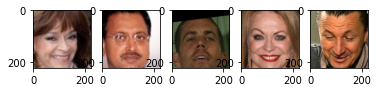

In [97]:
train_data = mx.image.ImageIter(batch_size=32,data_shape=(3, 224, 224),path_imgrec='/content/faces_ms1m_112x112/train.rec',path_imgidx='/content/faces_ms1m_112x112/train.idx',shuffle=True)

train_data.reset()
data_batch = train_data.next()
data = data_batch.data[0]
print(data_batch)
print(data.shape)
print(data[0].shape)
plt.figure()
for i in range(5):
    save_image = data[i].astype('uint8').asnumpy().transpose((1, 2, 0))
    plt.subplot(1, 5, i + 1)
    plt.imshow(save_image)

img = BytesIO()
plt.savefig(img, format='png')
plt.show()

# Utility function that will export a plot to a base-64 encoded string that the model card will accept.
train_demo1 = base64.encodebytes(img.getvalue()).decode('utf-8')

Load part of the training set(Only 5)

/content/faces_ms1m_112x112/train.rec

[16066.]
<NDArray 1 @cpu(0)>
(3, 512, 512, 3)


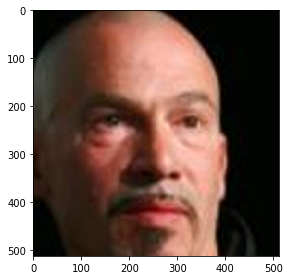


[45464.]
<NDArray 1 @cpu(0)>
(3, 512, 512, 3)


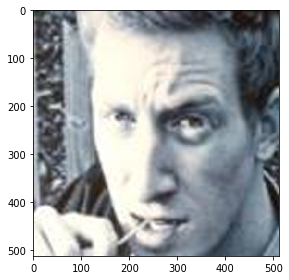


[53951.]
<NDArray 1 @cpu(0)>
(3, 512, 512, 3)


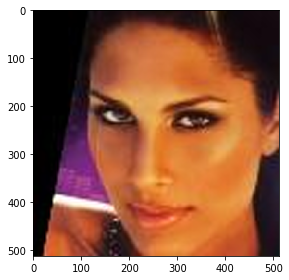


[40726.]
<NDArray 1 @cpu(0)>
(3, 512, 512, 3)


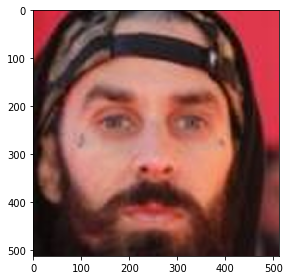


[73320.]
<NDArray 1 @cpu(0)>
(3, 512, 512, 3)


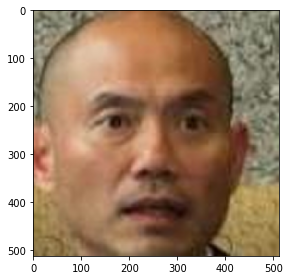

In [18]:
import mxnet.ndarray as nd
from skimage import io

rec_path = '/content/faces_ms1m_112x112/train.rec'
idx_path = '/content/faces_ms1m_112x112/train.idx'
print(rec_path)
for i in range(5):
  train_iter = mx.image.ImageIter(batch_size=3,data_shape=(3, 512, 512),path_imgrec=rec_path,path_imgidx=idx_path,shuffle=True)
  train_iter.reset()
  for batch in train_iter:
    x = batch.data[0]
    y = batch.label[0]
    break
  print(y[0])
  img = nd.transpose(x, (0, 2, 3, 1))
  print(img.shape)
  io.imshow(img[0].asnumpy().astype(np.uint8))
  io.show()


TODO:Evaluate Model(From the Snapshot)

Waiting for the training output then we can define 'a'

In [ ]:
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    plt.subplot(3, 1, 1)
    plt.title('Loss', color='white')

    plt.subplot(3, 1, 2)
    title2 = plt.title('Train Accuracy', color='white')

    plt.subplot(3, 1, 3)
    plt.title('Validation Accuracy', color='white')


    plt.subplot(3, 1, 1)
    plt.plot(a.loss_history, 'o')

    plt.subplot(3, 1, 2)
    plt.plot(a.train_acc_history, '-o')

    plt.subplot(3, 1, 3)
    plt.plot(a.val_acc_history, '-o')

    plt.gcf().set_size_inches(15, 15)
    plt.show()

Create a Model Card

In [98]:
mct = mctlib.ModelCardToolkit()

model_card = mct.scaffold_assets()

Annotate information into model card

In [99]:
from model_card_toolkit import model_card_toolkit
model_card.model_details.name = 'Face Recognition MS1M-ArcFace Dataset'
model_card.model_details.overview = ('Tensorflow implementation for MobileFaceNet,the model recognizes whether there is a human face based on the image.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Model Cards Team', contact='model-cards@google.com')
]
model_card.model_details.license = 'Apache-2.0'
model_card.model_details.references = [
    'https://arxiv.org/ftp/arxiv/papers/1804/1804.07573.pdf',
    'https://github.com/sirius-ai/MobileFaceNet_TF'
]
model_card.model_details.version.name = str(uuid.uuid4())
model_card.model_details.version.date = str(date.today())

model_card.considerations.ethical_considerations = [{'name':'Manual selection of image sections to digitize could create selection bias',
    'mitigation_strategy':'Automate the selection process'} # Need Review
]

model_card.considerations.use_cases = ['Face recognition']
model_card.considerations.users = ['Security', 'ML researchers', 'Finance']
model_card.model_parameters.model_architecture = 'sklearn.ensemble.GradientBoostingClassifier' # Need Review

model_card.model_parameters.data.train.graphics.description = f'{data_batch} and data shape {data.shape}'
model_card.model_parameters.data.train.graphics.collection = [{'name': 'Train Samples 1', 'image': train_demo1}, {'name': 'Train Samples 2', 'image': train_demo2}]
model_card.model_parameters.data.train.name = "Training Dataset Samples"

# TODO
#model_card.model_parameters.data.eval.graphics.description = f'{len(X_test)} rows with {len(X_test.columns)} features'
#model_card.model_parameters.data.eval.graphics.collection = [{'name': 'Radius Train Set', 'image': mean_radius_test}, {'name': 'Texture Train Set', 'image': mean_texture_test}]
#model_card.model_parameters.data.eval.name = "Eval dataset"


#model_card.quantitative_analysis.graphics.description = 'ROC curve and confusion matrix'
#model_card.quantitative_analysis.graphics.collection = [{'name': 'ROC curve', 'image': roc_curve}, {'name': 'Confusion Matrix', 'image': confusion_matrix}]

mct.update_model_card_json(model_card)

In [100]:
# Return the model card document as an HTML page

html = mct.export_format()

display.display(display.HTML(html))

TODO:Add the RAInS Framework